In [371]:
import pandas as pd
import numpy as np
from math import erf
import matplotlib.pyplot as plt
%matplotlib inline

NUM_ITER = 10000

In [372]:
df = pd.read_csv("1976-2020-president.csv")

In [373]:
ELECTIONYEAR = 2024
df = df[df['year']<ELECTIONYEAR]


In [374]:
df['party_simplified'] = df['party_simplified'].apply(lambda x: x if x in ['DEMOCRAT', 'REPUBLICAN'] else '3RDPARTY')

# Step 2: Aggregate the votes for "3RDPARTY"
df_grouped = df.groupby(['year', 'state_po', 'party_simplified'], as_index=False).agg({'candidatevotes': 'sum'})

# Step 3: Pivot the table
matrix = df_grouped.pivot_table(index='state_po', columns=['party_simplified','year'], values='candidatevotes', fill_value=0)


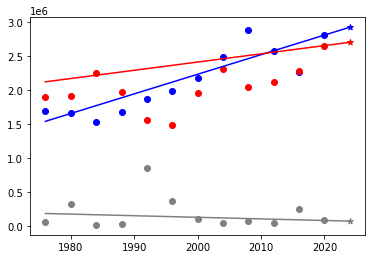

In [375]:
prior_preds = {}
for i,row in matrix.iterrows():
    t = row["DEMOCRAT"].index.values
    that = np.append(t,ELECTIONYEAR)

    X3 = row["3RDPARTY"].values
    m3 = np.std(X3)/np.std(t)*np.corrcoef(X3,t)[0,1]
    b3 = X3[-1] - m3*t[-1]
    X3hats = m3*that + b3
    X3hat2024 = m3*ELECTIONYEAR + b3
    X3var = np.sum((X3-X3hats[:-1])**2) / (len(X3) - 2) / 100 #Adjustment to fix weird near 0 issue


    XD = row["DEMOCRAT"].values
    mD = np.std(XD)/np.std(t)*np.corrcoef(XD,t)[0,1]
    bD = XD[-1] - mD*t[-1]
    XDhats = mD*that + bD
    XDhat2024 = mD*ELECTIONYEAR + bD
    XDvar = np.sum((XD-XDhats[:-1])**2) / (len(XD) - 2)

    XR = row["REPUBLICAN"].values
    mR = np.std(XR)/np.std(t)*np.corrcoef(XR,t)[0,1]
    bR = XR[-1] - mR*t[-1]
    XRhats = mR*that + bR
    XRhat2024 = mR*ELECTIONYEAR + bR
    XRvar = np.sum((XR-XRhats[:-1])**2) / (len(XR) - 2)
    if i=="MI":
        fig,ax = plt.subplots()
        ax.scatter(t,X3,color='grey')
        ax.plot(that,X3hats,color='grey')
        ax.scatter(ELECTIONYEAR,X3hat2024,color='grey',marker='*')

        ax.scatter(t,XD,color='blue')
        ax.plot(that,XDhats,color='blue')
        ax.scatter(ELECTIONYEAR,XDhat2024,color='blue',marker='*')

        ax.scatter(t,XR,color='red')
        ax.plot(that,XRhats,color='red')
        ax.scatter(ELECTIONYEAR,XRhat2024,color='red',marker='*')

    prior_preds[row.name] = {
        "other_vote":X3hat2024,
        "other_var":X3var,
        "dem_vote" :XDhat2024,
        "dem_var": XDvar,
        "rep_vote": XRhat2024,
        "rep_var":XRvar,    }


In [376]:
prior_preds = pd.DataFrame(data=prior_preds).T

In [377]:
prior_vars_scaled = prior_preds[["other_var","dem_var","rep_var"]].copy()

prior_vars_scaled["other_var"] = (prior_vars_scaled["other_var"] / prior_preds["other_vote"]**2)*2 # Extrapolation penalty
prior_vars_scaled["dem_var"] = (prior_vars_scaled["dem_var"] / prior_preds["dem_vote"]**2)*2 
prior_vars_scaled["rep_var"] = (prior_vars_scaled["rep_var"] / prior_preds["rep_vote"]**2)*2


prior_preds_scaled = prior_preds[["other_vote","dem_vote","rep_vote"]].copy()
prior_preds_votes = prior_preds_scaled.sum(axis=1)
prior_preds_scaled=prior_preds_scaled.div(prior_preds_votes,axis=0,)
prior_preds_scaled['total_vote_pred'] = prior_preds_votes
prior_preds_scaled_normalised = prior_preds_scaled.apply(lambda col: (col - np.average(col,weights=prior_preds_scaled["total_vote_pred"])))

poll_other = 0.046
poll_dem = 0.473
poll_rep = 0.436

# poll_other = 0.057
# poll_dem = 0.482
# poll_rep = 0.461

# poll_other = 0.019
# poll_dem = 0.513
# poll_rep = 0.468

post_preds_scaled_normalised = prior_preds_scaled_normalised.copy()
post_preds_scaled_normalised['other_vote'] += poll_other
post_preds_scaled_normalised['dem_vote'] += poll_dem
post_preds_scaled_normalised['rep_vote'] += poll_rep
post_preds_scaled_normalised.drop("total_vote_pred",axis=1,inplace=True)
post_preds_scaled_normalised = post_preds_scaled_normalised.div(post_preds_scaled_normalised.sum(axis=1),axis=0)



post_vars_scaled = prior_vars_scaled + 0.08**2

In [378]:
poll_other+ poll_dem+ poll_rep

0.9550000000000001

In [379]:
electoralvotes = {
    "AL":9,
    "AK":3,
    "AZ":11,
    "AR":6,
    "CA":54,
    "CO":10,
    "CT":7,
    "DC":3,
    "DE":3,
    "FL":30,
    "GA":16,
    "HI":4,
    "ID":4,
    "IL":19,
    "IN":11,
    "IA":6,
    "KS":6,
    "KY":8,
    "LA":8,
    "ME":4,
    "MD":10,
    "MA":11,
    "MI":15,
    "MN":10,
    "MS":6,
    "MO":10,
    "MT":4,
    "NE":5,
    "NV":6,
    "NH":4,
    "NJ":14,
    "NM":5,
    "NY":28,
    "NC":16,
    "ND":3,
    "OH":17,
    "OK":7,
    "OR":8,
    "PA":19,
    "RI":4,
    "SC":9,
    "SD":3,
    "TN":11,
    "TX":40,
    "UT":6,
    "VT":3,
    "VA":13,
    "WA":12,
    "WV":4,
    "WI":10,
    "WY":3}	


In [380]:
covariance_matrix = matrix.T.corr()
def to_cov(row,column):
    return row * (column.loc[row.name]) * column

In [381]:
rep_cov = matrix['REPUBLICAN'].T.corr().apply(lambda row: to_cov(row,post_vars_scaled['rep_var']))
dem_cov = matrix['DEMOCRAT'].T.corr().apply(lambda row: to_cov(row,post_vars_scaled['dem_var']))
oth_cov = matrix['3RDPARTY'].T.corr().apply(lambda row: to_cov(row,post_vars_scaled['other_var']))

In [382]:
outputs = []
for _ in range(NUM_ITER):
    election = pd.DataFrame(data = [np.clip(np.random.multivariate_normal(post_preds_scaled_normalised["rep_vote"],rep_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds_scaled_normalised["dem_vote"],dem_cov),0,1),
                                    np.clip(np.random.multivariate_normal(post_preds_scaled_normalised["other_vote"],oth_cov),0,1)
                            ], columns=rep_cov.columns,index=["rep_share","dem_share","oth_share"]).T
    
    harris_popular_vote = np.average(election['dem_share'],weights=prior_preds_scaled["total_vote_pred"])
    trump_popular_vote = np.average(election['rep_share'],weights=prior_preds_scaled['total_vote_pred'])
    oth_popular_vote = np.average(election['oth_share'],weights=prior_preds_scaled['total_vote_pred'])
    
    election['margin']=election["dem_share"] - election["rep_share"]
    election.sort_values(by='margin',ascending=False,inplace=True)

    election['winner']=["Harris"if res else "Trump" for res in election['margin']>0 ]

    election["Cummulative Trump EV"] = 0
    election["Cummulative Harris EV"] = 0



    harris_ev = 0
    trump_ev = 0
    other_ev = 0


    for state_name, result in election.iterrows():
        if result['winner']=="Harris":
            harris_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Harris EV"] = harris_ev

    election.sort_values(by='margin',ascending=True,inplace=True)
    for state_name, result in election.iterrows():
        if result['winner']=="Trump":
            trump_ev += electoralvotes[state_name]
            election.loc[state_name,"Cummulative Trump EV"] = trump_ev

    # Check if Electoral Vote Tie
    if (election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any().all():
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]==269).any(axis=1)]['margin'].abs().idxmin()
    else:
        tipping_point_state = election[(election[["Cummulative Harris EV","Cummulative Trump EV"]]>= 270).any(axis=1)][["Cummulative Harris EV","Cummulative Trump EV"]].sum(axis=1).idxmin()
 


    output_df = election[["rep_share","dem_share","oth_share","winner"]]
    output = {
        "df":output_df,
        "facts":{
            "harris_popular_vote":harris_popular_vote,
            "trump_popular_vote":trump_popular_vote,
            "oth_popular_vote":oth_popular_vote,
            "tipping_point_state":tipping_point_state,
            "harris_ev":harris_ev
        }
    }
    outputs.append(output)

In [383]:
election

,rep_share,dem_share,oth_share,margin,winner,Cummulative Trump EV,Cummulative Harris EV
state_po,,,,,,,
WV,0.860308,0.218765,0.289423,-0.641543,Trump,4,0
WY,0.771138,0.197885,0.117120,-0.573254,Trump,7,0
ID,0.793655,0.318044,0.112659,-0.475611,Trump,11,0
AR,0.722410,0.272263,0.084883,-0.450147,Trump,17,0
ND,0.750344,0.302217,0.161651,-0.448127,Trump,20,0
OK,0.724910,0.282956,0.302844,-0.441953,Trump,27,0
SD,0.721369,0.320080,0.174460,-0.401289,Trump,30,0
KY,0.686482,0.315484,0.125722,-0.370998,Trump,38,0
TN,0.686549,0.320657,0.076111,-0.365892,Trump,49,0


In [384]:
combined_df = pd.concat([output['df'] for output in outputs],axis=0)
median_df = combined_df.groupby(level=0).median()

In [385]:
def ensure_harris(counts):
    if "Harris" not in counts:
        counts["Harris"] = 0
    return counts
state_probs = combined_df.groupby(combined_df.index)["winner"].apply(lambda x: x.value_counts())
state_probs = state_probs.groupby(level=0).apply(ensure_harris)
state_probs = state_probs.reset_index(level=1, drop=True).unstack(fill_value=0).drop('',axis=1)

In [386]:
model_outputs = {}
for i,row in median_df.iterrows():
    p_dem_win = state_probs.loc[i,"Harris"] / state_probs.loc[i].sum()
    dem_margin_median = row["dem_share"] - row["rep_share"]


    model_outputs[i] = {
        "Probability Harris Win":p_dem_win,
        "Median Harris Margin":dem_margin_median,
        "Harris Voteshare":row["dem_share"],
        "Trump Voteshare":row["rep_share"],
        "Other Voteshare":row["oth_share"],
        "Total Number of Votes":prior_preds_scaled.loc[i,"total_vote_pred"],
        "EV":electoralvotes[i]
    }
model_outputs = pd.DataFrame(data = model_outputs).T

In [387]:
text = model_outputs.apply(lambda row:
                           f" <b><i>{df[['state','state_po']].set_index('state_po').to_dict()['state'][row.name]}</i> {int(row['EV'])} EV's</b> \
                           <br><i>Probability Harris Wins</i>: <b>{np.round(row['Probability Harris Win']*100,1)}%</b> \
                           <br><i>Predicted Harris Voteshare</i>: <b>{np.round(row['Harris Voteshare']*100,1)}%</b> \
                            <br><i>Predicted Trump Voteshare</i>: <b>{np.round(row['Trump Voteshare']*100,1)}%</b> \
                           <br><i>Predicted Other Voteshare</i>: <b>{np.round(row['Other Voteshare']*100,1)}%</b> \
                            ",axis=1)

In [388]:
republican_red = "#cf1313"
democratic_blue = "#116dc2"
chloropleth_cmap = [(0, republican_red),(0.5,"white"), (1, democratic_blue)]
histogram_cmap = [(0, "red"),(0.4, "red"), (0.5,"#c478b1"), (0.6, "blue"), (1, "blue")]

In [389]:
import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=model_outputs.index, # Spatial coordinates
    z = model_outputs["Probability Harris Win"], # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = chloropleth_cmap,
    # colorbar_title = "Probability Harris Win",
    text = text,
    hoverinfo="text",
    showscale=False
))

fig.update_layout(
    # title_text = f'2024 Electoral Forecast: Kamala Harris has a {OVERALL["Probability Harris Win"].round(3)*100}% chance to win the election',
    geo_scope='usa', # limite map scope to USA
    title=None,  # Remove title
    margin={"r":0,"t":0,"l":0,"b":0},  # Adjust margins to remove extra space
)

fig.write_html("./chloropleth.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [390]:
run = [output['facts']['harris_ev'] for output in outputs]

In [391]:
counts,bins = np.histogram(run,bins=85,range=(100,440))

In [392]:
text = [f"<b>Harris wins between {int(bins[i])} and {int(bins[i+1])} EV's in {count} runs \
        <br> out of {sum(counts)} simulations </b>" for i,count in enumerate(counts)]

In [393]:
fig = go.Figure(data=[go.Bar(
    x=bins,
    y=counts/sum(counts)*100,
    marker={'color': bins, 'colorscale': histogram_cmap},
    text =text,    
    hoverinfo='text',
    textposition = "none"
    )])
# Add titles and labels
fig.update_layout(
    # title='Histogram of Electoral Votes',
    xaxis_title='Harris Electoral College Vote',
    yaxis_title='Probability %',
)
fig.add_shape(
    go.layout.Shape(
        type='line',
        x0=270,
        y0=0,
        x1=270,
        y1=max(fig.data[0].y)*1.2,  # Adjust y1 to match the range of your data
        line=dict(
            color='Black',
            width=2,
            dash='dot',  # Dotted line
        ),
    )
)
fig.add_annotation(
    x=270,
    y=max(fig.data[0].y),  # Position text slightly below the top of the y-axis
    text="<b>Harris wins the election<b><br>---------->",
    showarrow=True,
    arrowhead=0,
    ax=85,  # X offset for the text
    ay=0,   # Y offset for the text
    font=dict(size=12, color="Black"),
    align='left'
)
fig.update_layout(
    paper_bgcolor='rgba(0,0,0,0)',
    plot_bgcolor='rgba(0,0,0,0)',
)

# fig.show()
fig.write_html("./histogram.html",config={'displayModeBar': False,"responsive": True,"scrollZoom":False})

In [394]:
pwin = sum([output['facts']['harris_ev']>=270 for output in outputs])/NUM_ITER
median_ev = np.median([output['facts']['harris_ev'] for output in outputs])

In [408]:
(pd.Series([output['facts']['harris_popular_vote']-output['facts']['trump_popular_vote'] for output in outputs])>0).value_counts()

True     7376
False    2624
dtype: int64

In [396]:
pwin

0.5405

In [397]:
median_ev

276.0

In [398]:
tipping_points = pd.Series([output['facts']['tipping_point_state'] for output in outputs])
tipping_points.value_counts()/tipping_points.value_counts().sum()

PA    0.2572
WI    0.2443
TX    0.1042
AZ    0.0820
MI    0.0652
NC    0.0651
GA    0.0617
NV    0.0327
FL    0.0234
MN    0.0148
NY    0.0130
IL    0.0094
NH    0.0059
VA    0.0055
UT    0.0031
NJ    0.0029
ME    0.0028
CO    0.0022
RI    0.0013
CT    0.0009
HI    0.0008
NM    0.0007
IA    0.0007
AK    0.0001
OH    0.0001
dtype: float64